<a href="https://colab.research.google.com/github/Audrey-Lily/50projects50days/blob/master/%E7%BB%8F%E5%85%B8Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

100%|██████████| 714M/714M [00:32<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [ ]:
import os
import cv2
import time
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid

from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-3-ff30930eead4>:20: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2/kaggle_3m/'
data_dir = glob(f'{data_dir}/*/*[0-9].tif')

In [ ]:
csv_path = '/root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

missing_values_count = df.isnull().sum()
missing_values_count

,0
Patient,0
RNASeqCluster,18
MethylationCluster,1
miRNACluster,0
CNCluster,2
RPPACluster,12
OncosignCluster,5
COCCluster,0
histological_type,1
neoplasm_histologic_grade,1


In [ ]:
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0


In [ ]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

In [ ]:
PathDF = pd.DataFrame((get_file_row(filename) for filename in data_dir), columns=['Patient', 'image', 'mask'])
PathDF.head()

,Patient,image,mask
0,TCGA_FG_7637,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
1,TCGA_FG_7637,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
2,TCGA_FG_7637,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
3,TCGA_FG_7637,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
4,TCGA_FG_7637,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...


In [ ]:
class MRI_Dataset(Dataset):
    def __init__(self, df, transform=None):
        super(MRI_Dataset, self).__init__()
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        img = transforms.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [ ]:
df = pd.merge(df, PathDF, on="Patient")

In [ ]:
train_df, rest = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(rest, test_size=0.3, random_state=42)

print(f"Train: {train_df.shape[0]} | Validation: {valid_df.shape[0]} | Test: {test_df.shape[0]}")

Train: 2750 | Validation: 354 | Test: 825


In [ ]:
transform = albumentations.Compose([
    albumentations.ChannelDropout(p=0.3),
    albumentations.RandomBrightnessContrast(p=0.3),
    albumentations.ColorJitter(p=0.3),
])

train_dataset = MRI_Dataset(train_df, transform)
valid_dataset = MRI_Dataset(valid_df)
test_dataset = MRI_Dataset(test_df)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

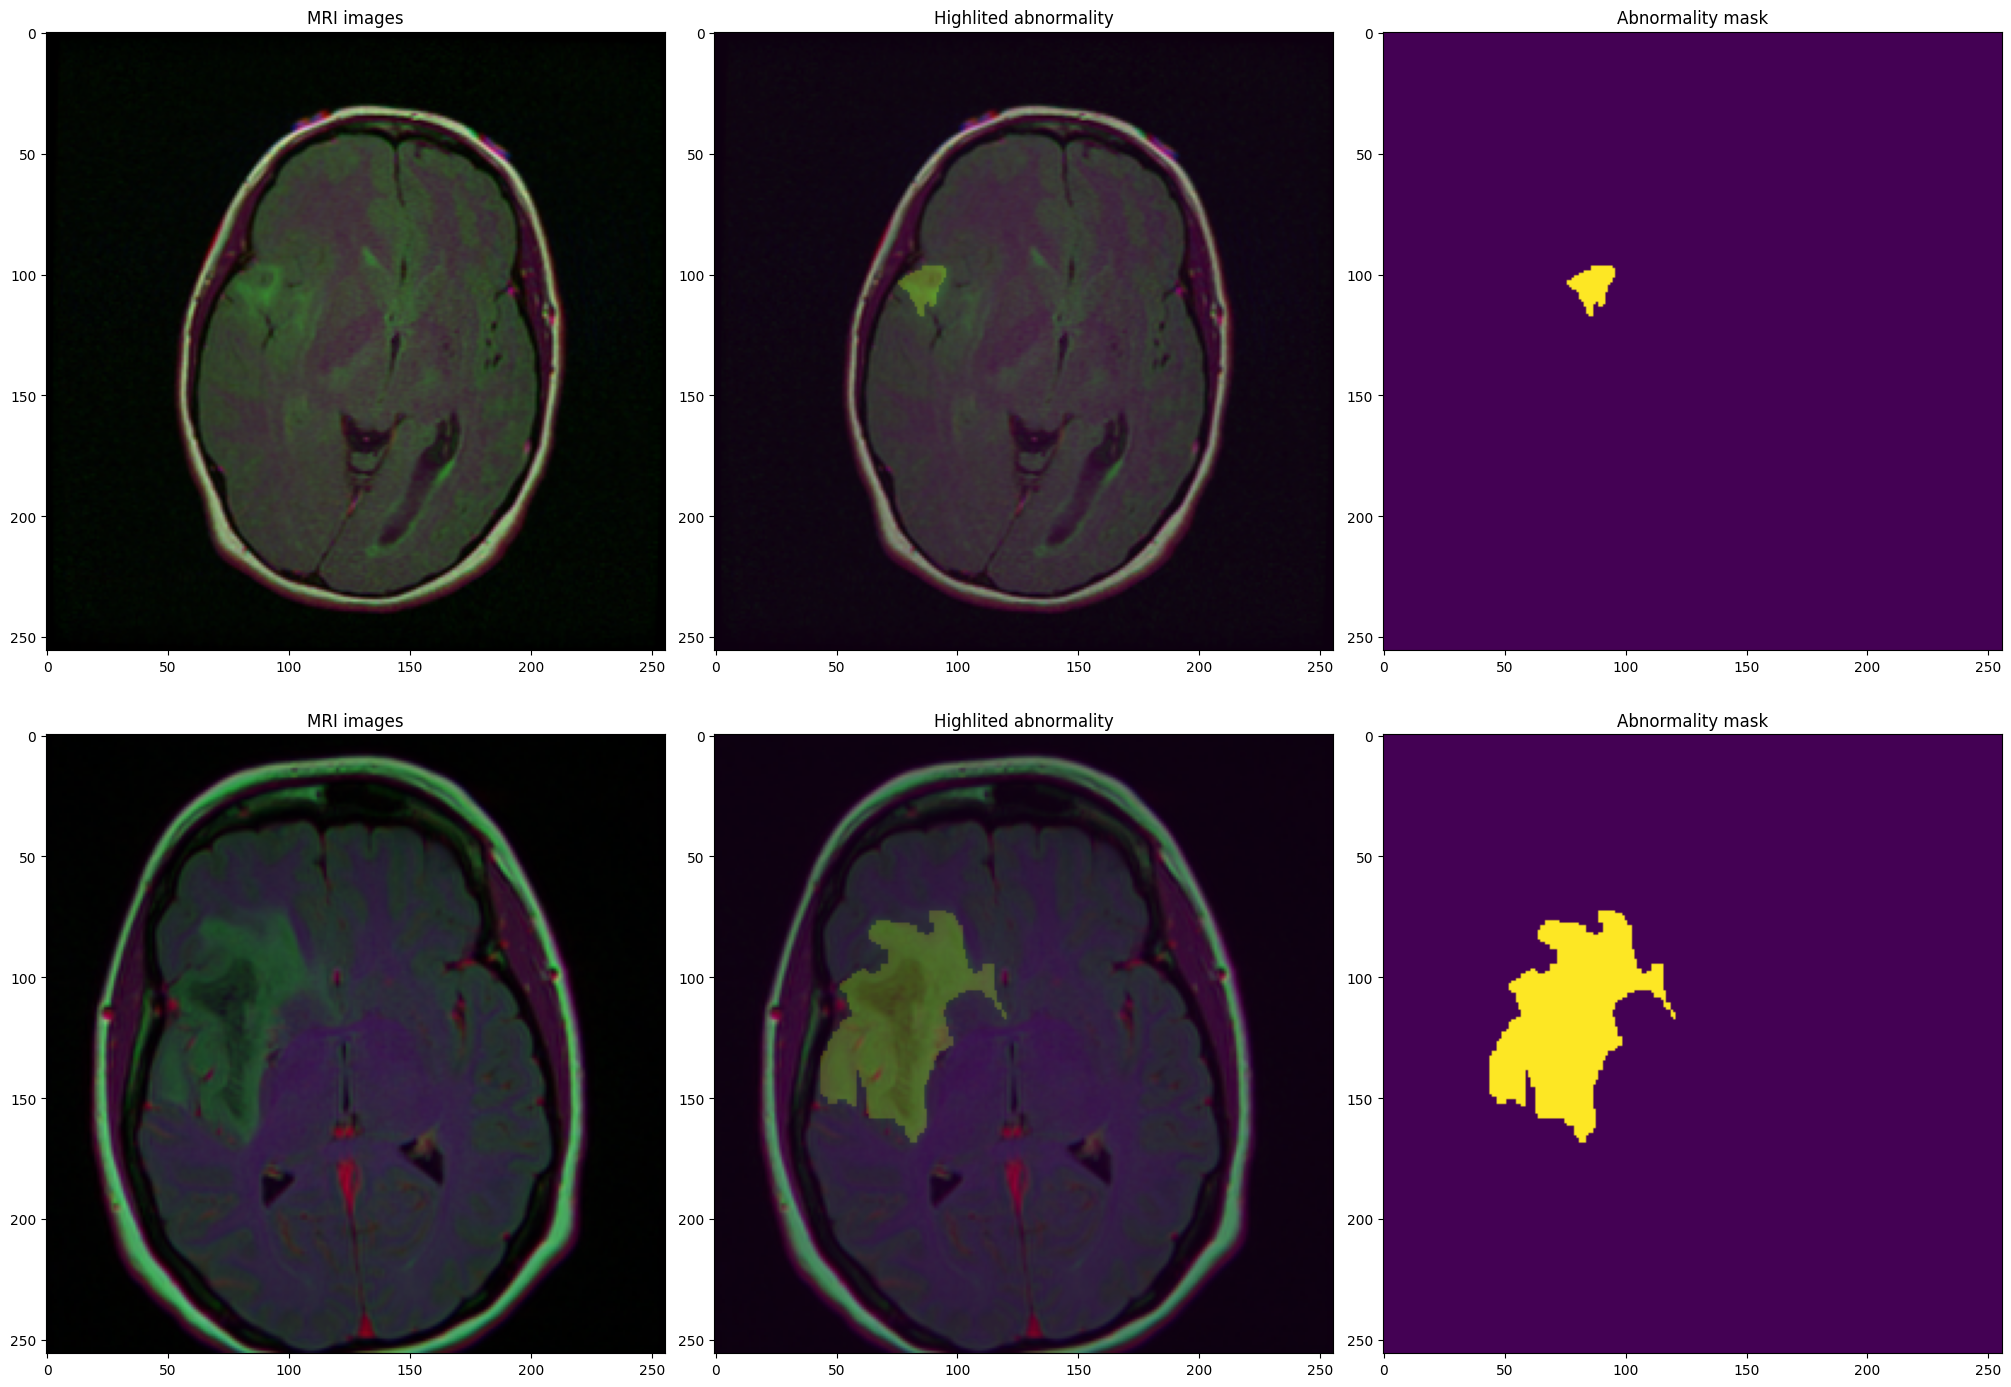

In [ ]:
%matplotlib inline
n_examples = 2

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask):
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break

In [ ]:
class double_convolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_convolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(downsample_block, self).__init__()
        self.Downconv = nn.Sequential(
            nn.MaxPool2d(2,2),
            double_convolution(in_channels, out_channels)
         )
    def forward(self, x):
        x = self.Downconv(x)
        return x

In [ ]:
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64)
        self.down1 = downsample_block(64, 128)
        self.down2 = downsample_block(128, 256)
        self.down3 = downsample_block(256, 512)
        self.down4 = downsample_block(512, 512)
        self.up1 = upsample_block(1024, 256)
        self.up2 = upsample_block(512, 128)
        self.up3 = upsample_block(256, 64)
        self.up4 = upsample_block(128, 64)
        self.outc = OutConv(64, num_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
model.to(device);

In [ ]:
# Define our learning rate, loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 15

In [ ]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        running_loss = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss}')
    model.eval()
    return history

In [ ]:
history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn)

100%|██████████| 172/172 [01:53<00:00,  1.51it/s]


Epoch: 1/15 | Training loss: 0.13564125516468828 | Validation loss: 0.050715234635745066


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 2/15 | Training loss: 0.034014432075348766 | Validation loss: 0.027312879003373917


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 3/15 | Training loss: 0.02410735952041366 | Validation loss: 0.020805996041587095


100%|██████████| 172/172 [02:03<00:00,  1.40it/s]


Epoch: 4/15 | Training loss: 0.021988828126679766 | Validation loss: 0.019732139907293233


100%|██████████| 172/172 [02:03<00:00,  1.40it/s]


Epoch: 5/15 | Training loss: 0.018481394843621688 | Validation loss: 0.01750871412571793


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 6/15 | Training loss: 0.01775997418300672 | Validation loss: 0.028623766934046637


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 7/15 | Training loss: 0.01673888395862146 | Validation loss: 0.0147903777900978


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 8/15 | Training loss: 0.01663349634950811 | Validation loss: 0.01585220606960777


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 9/15 | Training loss: 0.014421121001582254 | Validation loss: 0.013118988688637917


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 10/15 | Training loss: 0.014207385890863159 | Validation loss: 0.01684053699712211


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 11/15 | Training loss: 0.01348781056702137 | Validation loss: 0.013246178242909369


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 12/15 | Training loss: 0.012427891873500563 | Validation loss: 0.015403144177323008


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 13/15 | Training loss: 0.011711285672404549 | Validation loss: 0.011037976565207802


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 14/15 | Training loss: 0.010894054853780703 | Validation loss: 0.013542386359702218


100%|██████████| 172/172 [02:03<00:00,  1.39it/s]


Epoch: 15/15 | Training loss: 0.011323348625817083 | Validation loss: 0.013916154702504476


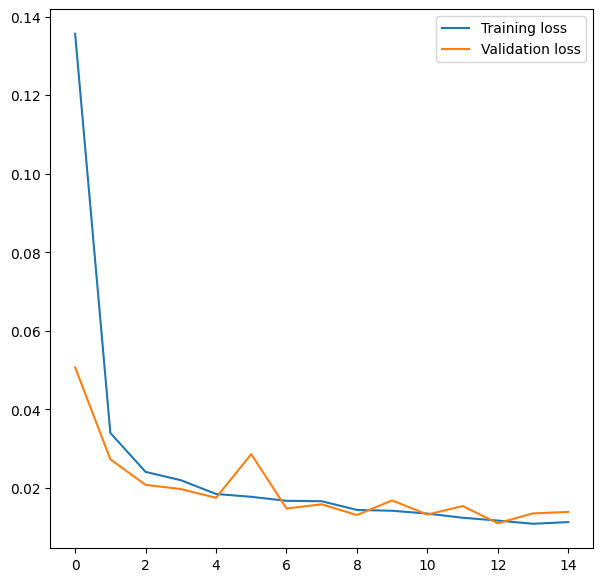

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    running_loss = 0
    for i, data in enumerate(test_loader):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        predictions = model(img)
        predictions = predictions.squeeze(1)
        loss = loss_fn(predictions, mask)
        running_loss += loss.item() * img.size(0)
    loss = running_loss / len(test_dataset)

    print(f'Tests: loss: {loss}')

Tests: loss: 0.013911633605356187


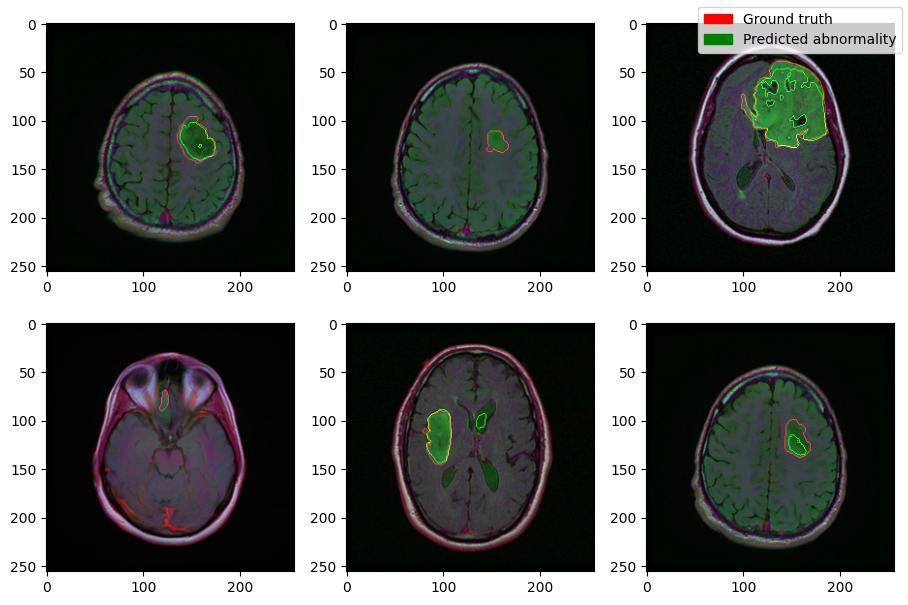

In [ ]:
%matplotlib inline

width = 3
columns = 2
n_examples = 6

fig, axs = plt.subplots(columns, width, figsize=(3*width , 3*columns), constrained_layout=True)
red_patch = mpatches.Patch(color='red', label='The red data')
fig.legend(loc='upper right',handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')])
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0]
        if not mask.byte().any():
            continue
        image = image.to(device)
        prediction = model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        prediction_edges = prediction - binary_dilation(prediction)
        ground_truth = mask - binary_dilation(mask)
        image[0, 0, ground_truth.bool()] = 1
        image[0, 1, prediction_edges.bool()] = 1

        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        if n_examples == i + 1:
            break
        i += 1